# TODO - ROC curves, minimal equal error rate plot, evaulation of ROC over time (overlay with average?)
# Implement gridsearch to optimise the model? (Use validation set of data)
Working on this problem: https://www.cs.cmu.edu/~keystroke/.
Supporting paper: http://www.cs.cmu.edu/~keystroke/KillourhyMaxion09.pdf

Data comes from 51 subjects typing ".tie5Roanl" 400 times across multiple sessions.

Our goal is to develop a model which has a minimal equal error rate. 

(Diagram of minimal equal error rate https://api.intechopen.com/media/chapter/66135/media/F2.png).

Questions that immediately need answering:
- What type of problem is this (classification or regression)?
- Has anyone attempted this problem before?
    - If so, how did they approach it? 
        - Which detectors / feature sets / models did they use?
        - What was successful about their approach? 
        - What were their limitations?
- What do the features in the dataset represent?
- Which do we prioritise - false poitives or false negatives (aka in this context: false-alarm rates and miss rates).
    - From the literature (and common sense to be honest), we should prioritise lowering miss rates (it's better to lock out a user, than have a threat access the system).

These were largely answered through reading the aforementioned paper, and doing some background reading and research.

The aforementioned paper also detailed a method by which different detectors could be compared on the same dataset. So to evaluate how our 'new' model performs against its competitors, it makes sense to first implement a pre-existing model, then our new model, and compare performance under the same conditions.

Note: The paper implemented the techniques using R (which I've not used before). Implementation in Python _should_ be the same, but there may be some underlying differences in R/Python's mathematics libraries

# Imports and file processing
Let's import some relevant modules and see what the file's contents are.

In [1]:
# First, imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read in csv file and check what's inside
df = pd.read_csv('DSL-StrongPasswordData.csv')
df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


# Exploratory Analysis

In [3]:
df.info()
# 20,400 rows, 34 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 34 columns):
subject            20400 non-null object
sessionIndex       20400 non-null int64
rep                20400 non-null int64
H.period           20400 non-null float64
DD.period.t        20400 non-null float64
UD.period.t        20400 non-null float64
H.t                20400 non-null float64
DD.t.i             20400 non-null float64
UD.t.i             20400 non-null float64
H.i                20400 non-null float64
DD.i.e             20400 non-null float64
UD.i.e             20400 non-null float64
H.e                20400 non-null float64
DD.e.five          20400 non-null float64
UD.e.five          20400 non-null float64
H.five             20400 non-null float64
DD.five.Shift.r    20400 non-null float64
UD.five.Shift.r    20400 non-null float64
H.Shift.r          20400 non-null float64
DD.Shift.r.o       20400 non-null float64
UD.Shift.r.o       20400 non-null float64
H.o           

In [4]:
df.describe()
# Mean DD looks to be ~ double H and UD

,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
count,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,...,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000
mean,4.500000,25.500000,0.093379,0.264148,0.170769,0.085727,0.169085,0.083358,0.081565,0.159372,...,0.106259,0.150670,0.044411,0.089899,0.202630,0.112731,0.095589,0.321847,0.226259,0.088306
std,2.291344,14.431223,0.029626,0.220534,0.226836,0.027424,0.123546,0.125755,0.026887,0.226928,...,0.038828,0.107422,0.105197,0.030738,0.150191,0.159571,0.028348,0.225389,0.230759,0.027452
min,1.000000,1.000000,0.001400,0.018700,-0.235800,0.009300,0.001100,-0.162100,0.003200,0.001400,...,0.004000,0.001100,-0.235500,0.003700,0.001300,-0.175800,0.003700,0.008300,-0.124500,0.002900
25%,2.750000,13.000000,0.074400,0.146900,0.049800,0.066000,0.113600,0.027200,0.062000,0.089300,...,0.082100,0.096100,-0.009000,0.067300,0.127600,0.023500,0.077400,0.210000,0.114100,0.069900
50%,4.500000,25.500000,0.089500,0.205950,0.108700,0.081000,0.140400,0.057800,0.077100,0.120900,...,0.101900,0.125000,0.022700,0.085300,0.172500,0.095500,0.093700,0.263000,0.160300,0.085500
75%,6.250000,38.000000,0.107900,0.306450,0.212400,0.099800,0.183900,0.096400,0.096900,0.173100,...,0.122300,0.174600,0.068900,0.107900,0.228800,0.145700,0.111100,0.350200,0.255100,0.103700
max,8.000000,50.000000,0.376100,12.506100,12.451700,0.241100,4.919700,4.799900,0.331200,25.987300,...,2.035300,3.327800,2.524200,0.357700,4.025200,3.978200,0.340700,5.883600,5.836400,0.265100


In [5]:
subjects = df["subject"].unique()
print(subjects) 
# Confirmation there are 51 unique subjects

['s002' 's003' 's004' 's005' 's007' 's008' 's010' 's011' 's012' 's013'
 's015' 's016' 's017' 's018' 's019' 's020' 's021' 's022' 's024' 's025'
 's026' 's027' 's028' 's029' 's030' 's031' 's032' 's033' 's034' 's035'
 's036' 's037' 's038' 's039' 's040' 's041' 's042' 's043' 's044' 's046'
 's047' 's048' 's049' 's050' 's051' 's052' 's053' 's054' 's055' 's056'
 's057']


In [6]:
sessions = df["sessionIndex"].unique()
print(sessions)
# 400 times across 8 sessions means each subject typed the string ~ 50 times per session

[1 2 3 4 5 6 7 8]


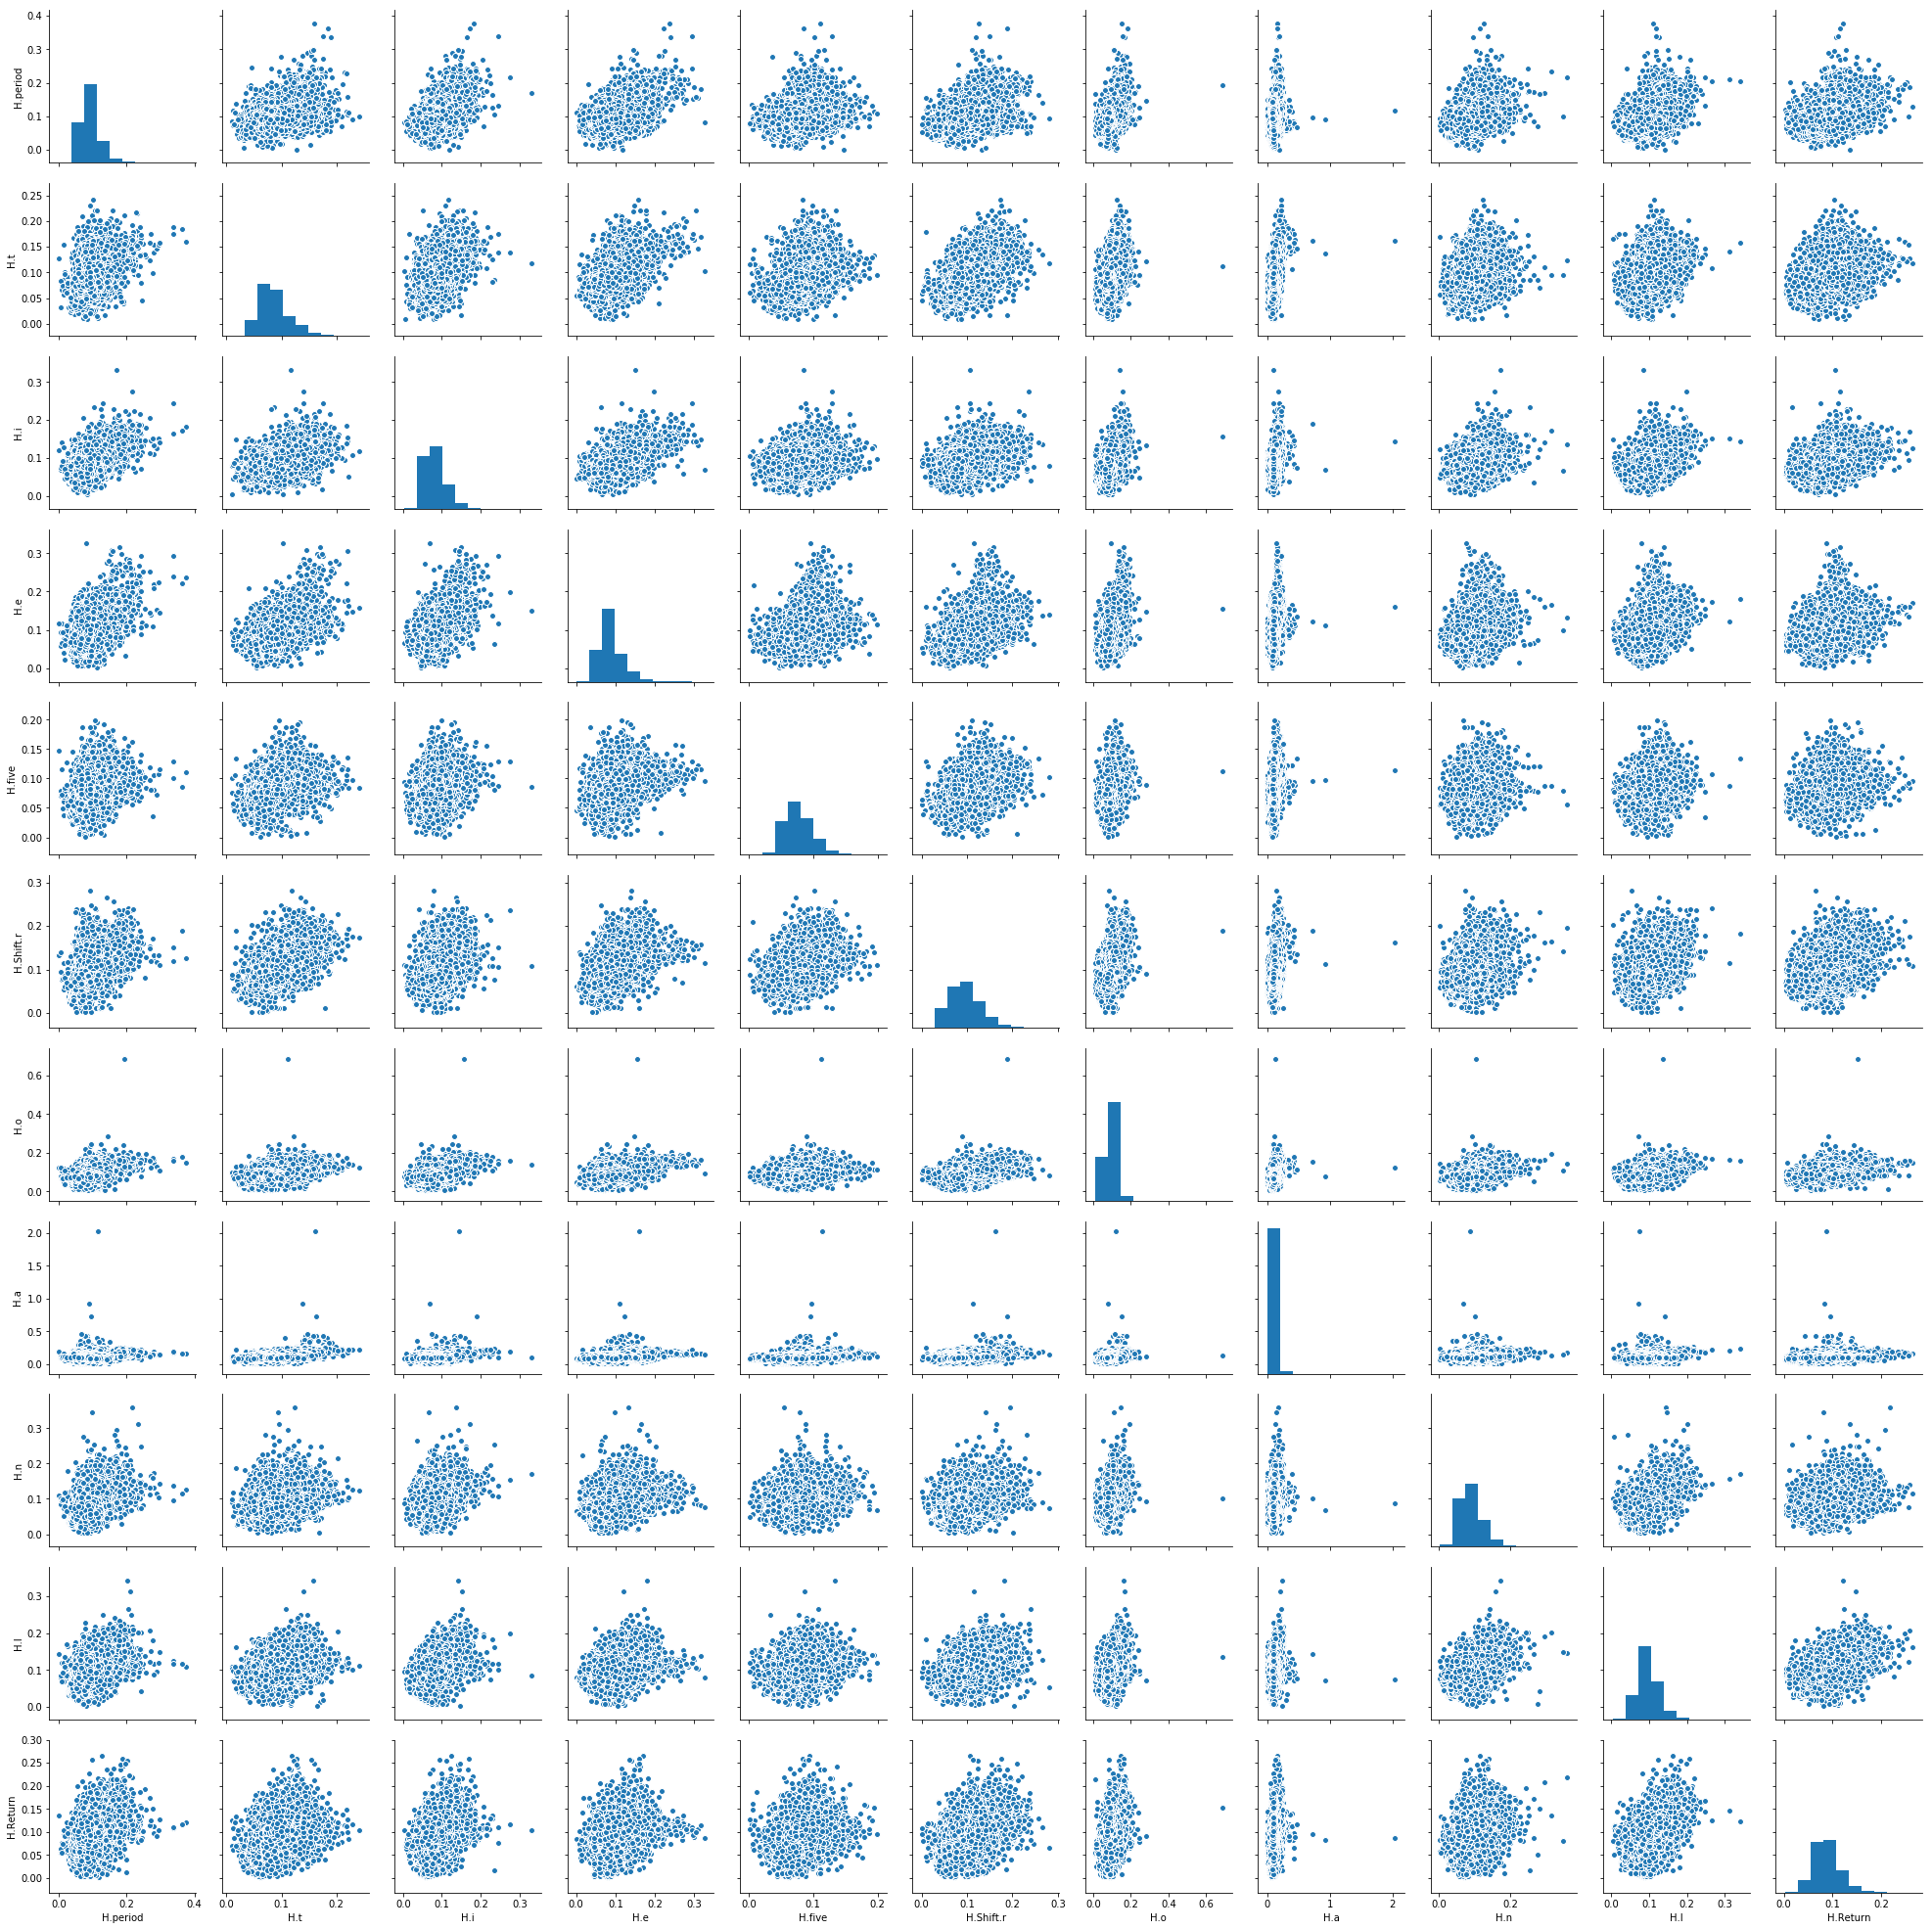

In [7]:
sns.pairplot(df.filter(['H.period','H.t','H.i','H.e','H.five','H.Shift.r','H.o','H.a','H.n','H.l','H.Return'],axis=1))

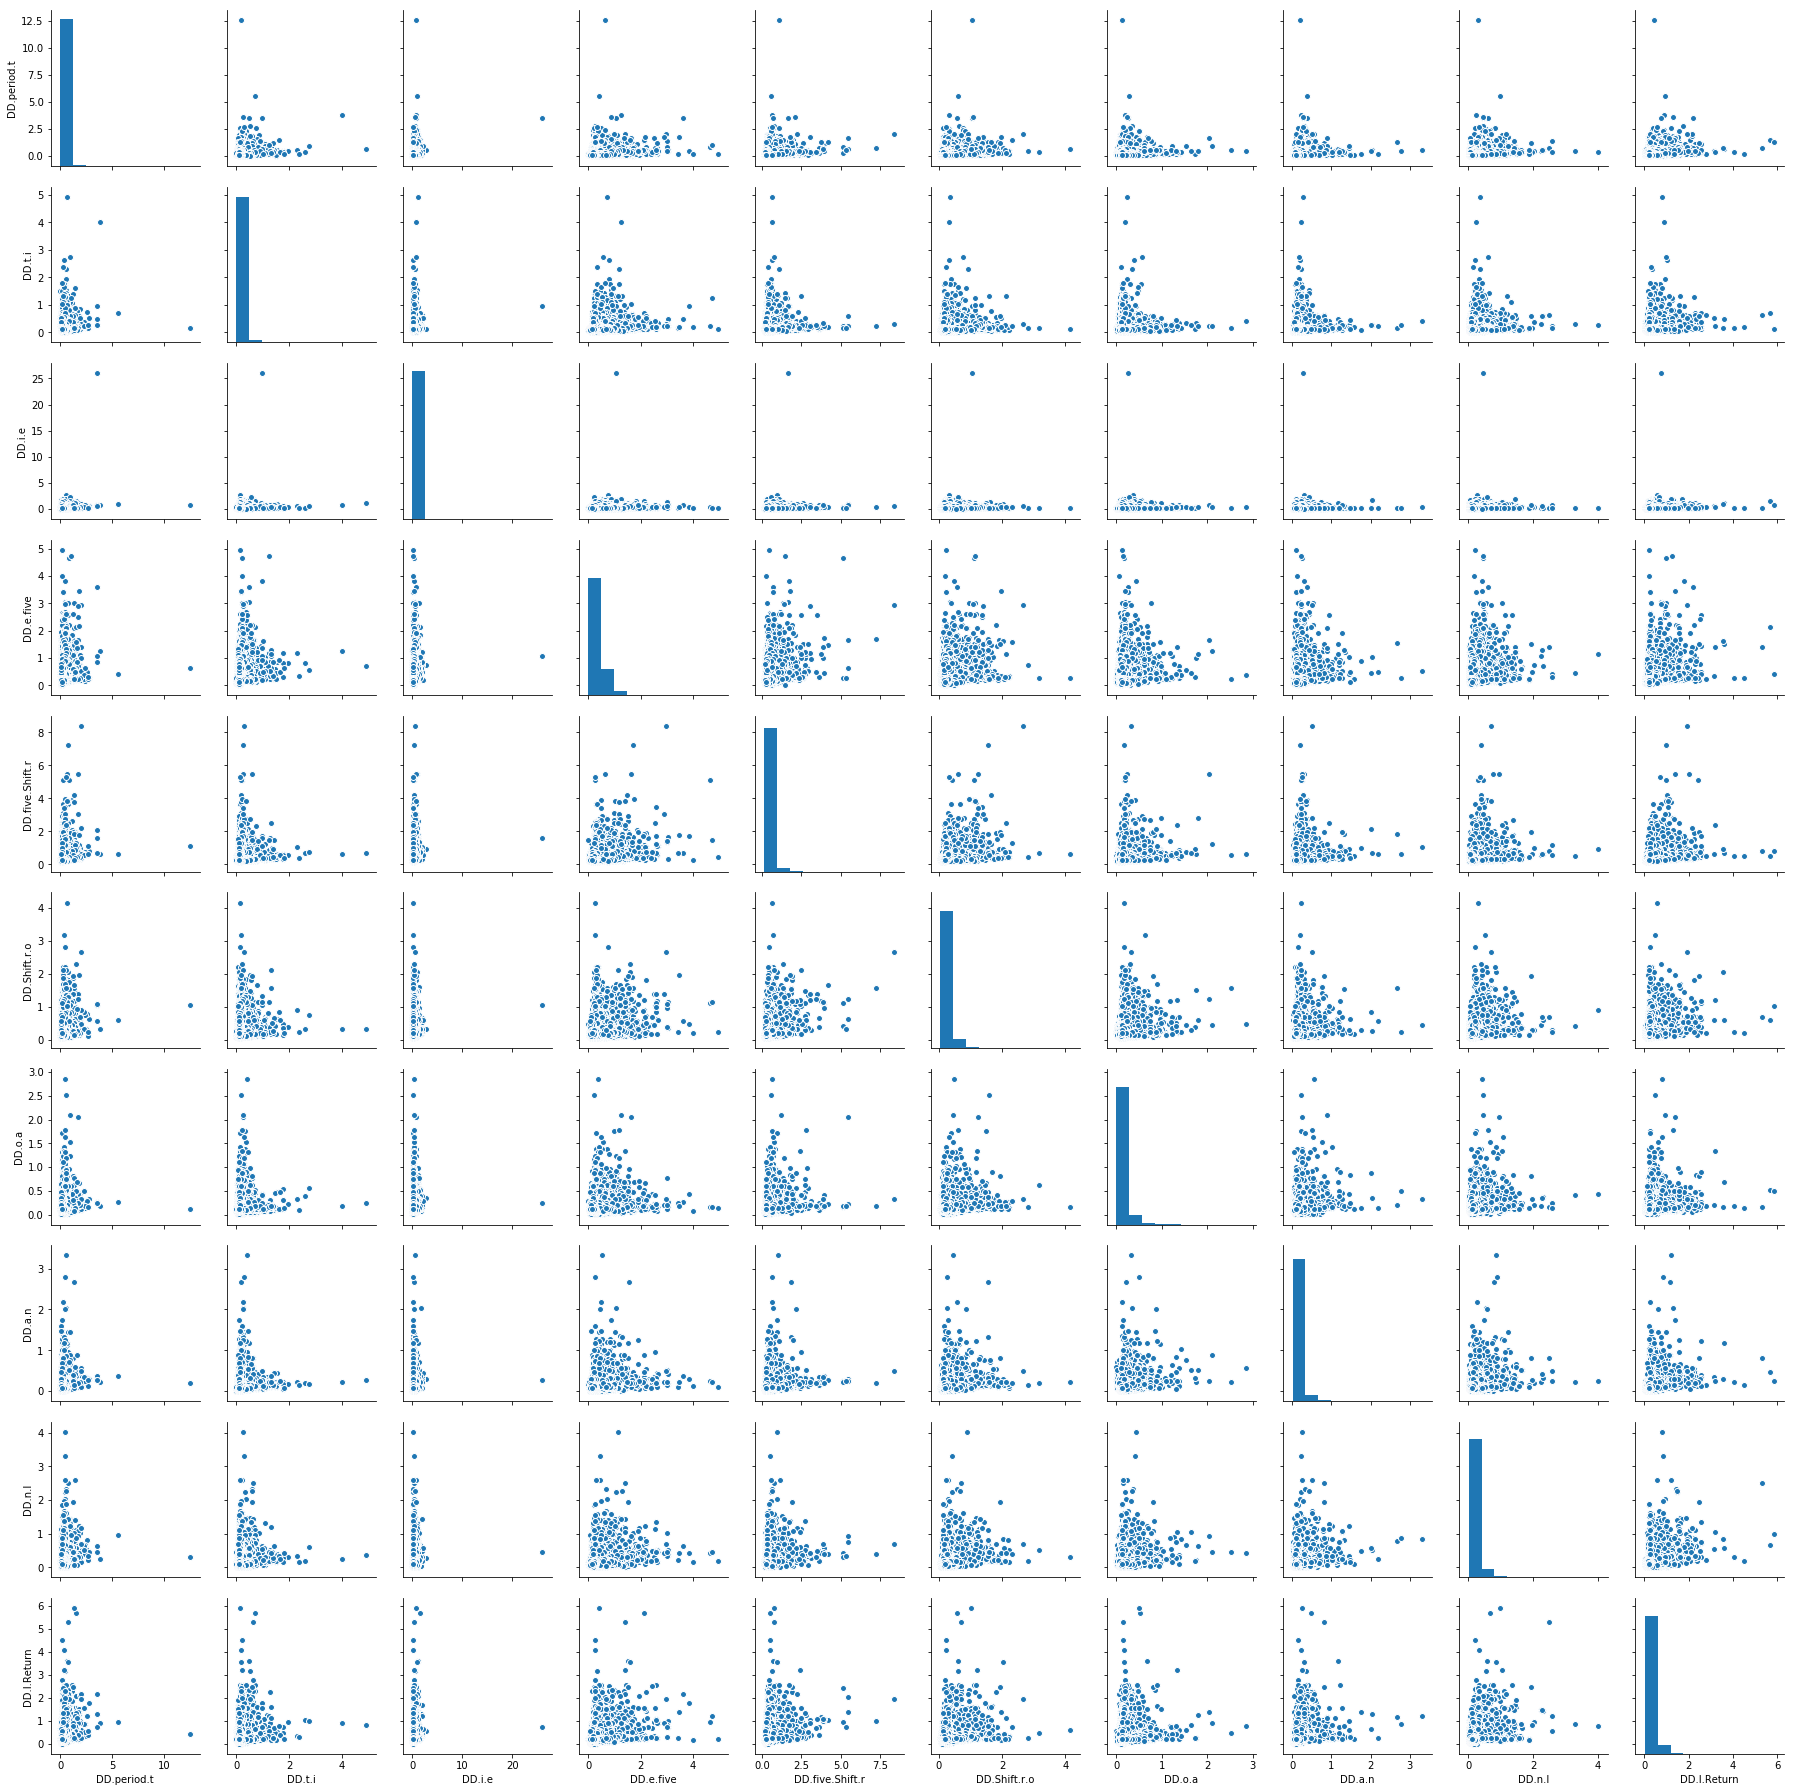

In [8]:
sns.pairplot(df.filter(['DD.period.t','DD.t.i','DD.i.e','DD.e.five','DD.five.Shift.r','DD.Shift.r.o','DD.o.a','DD.a.n','DD.n.l','DD.l.Return'],axis=1))

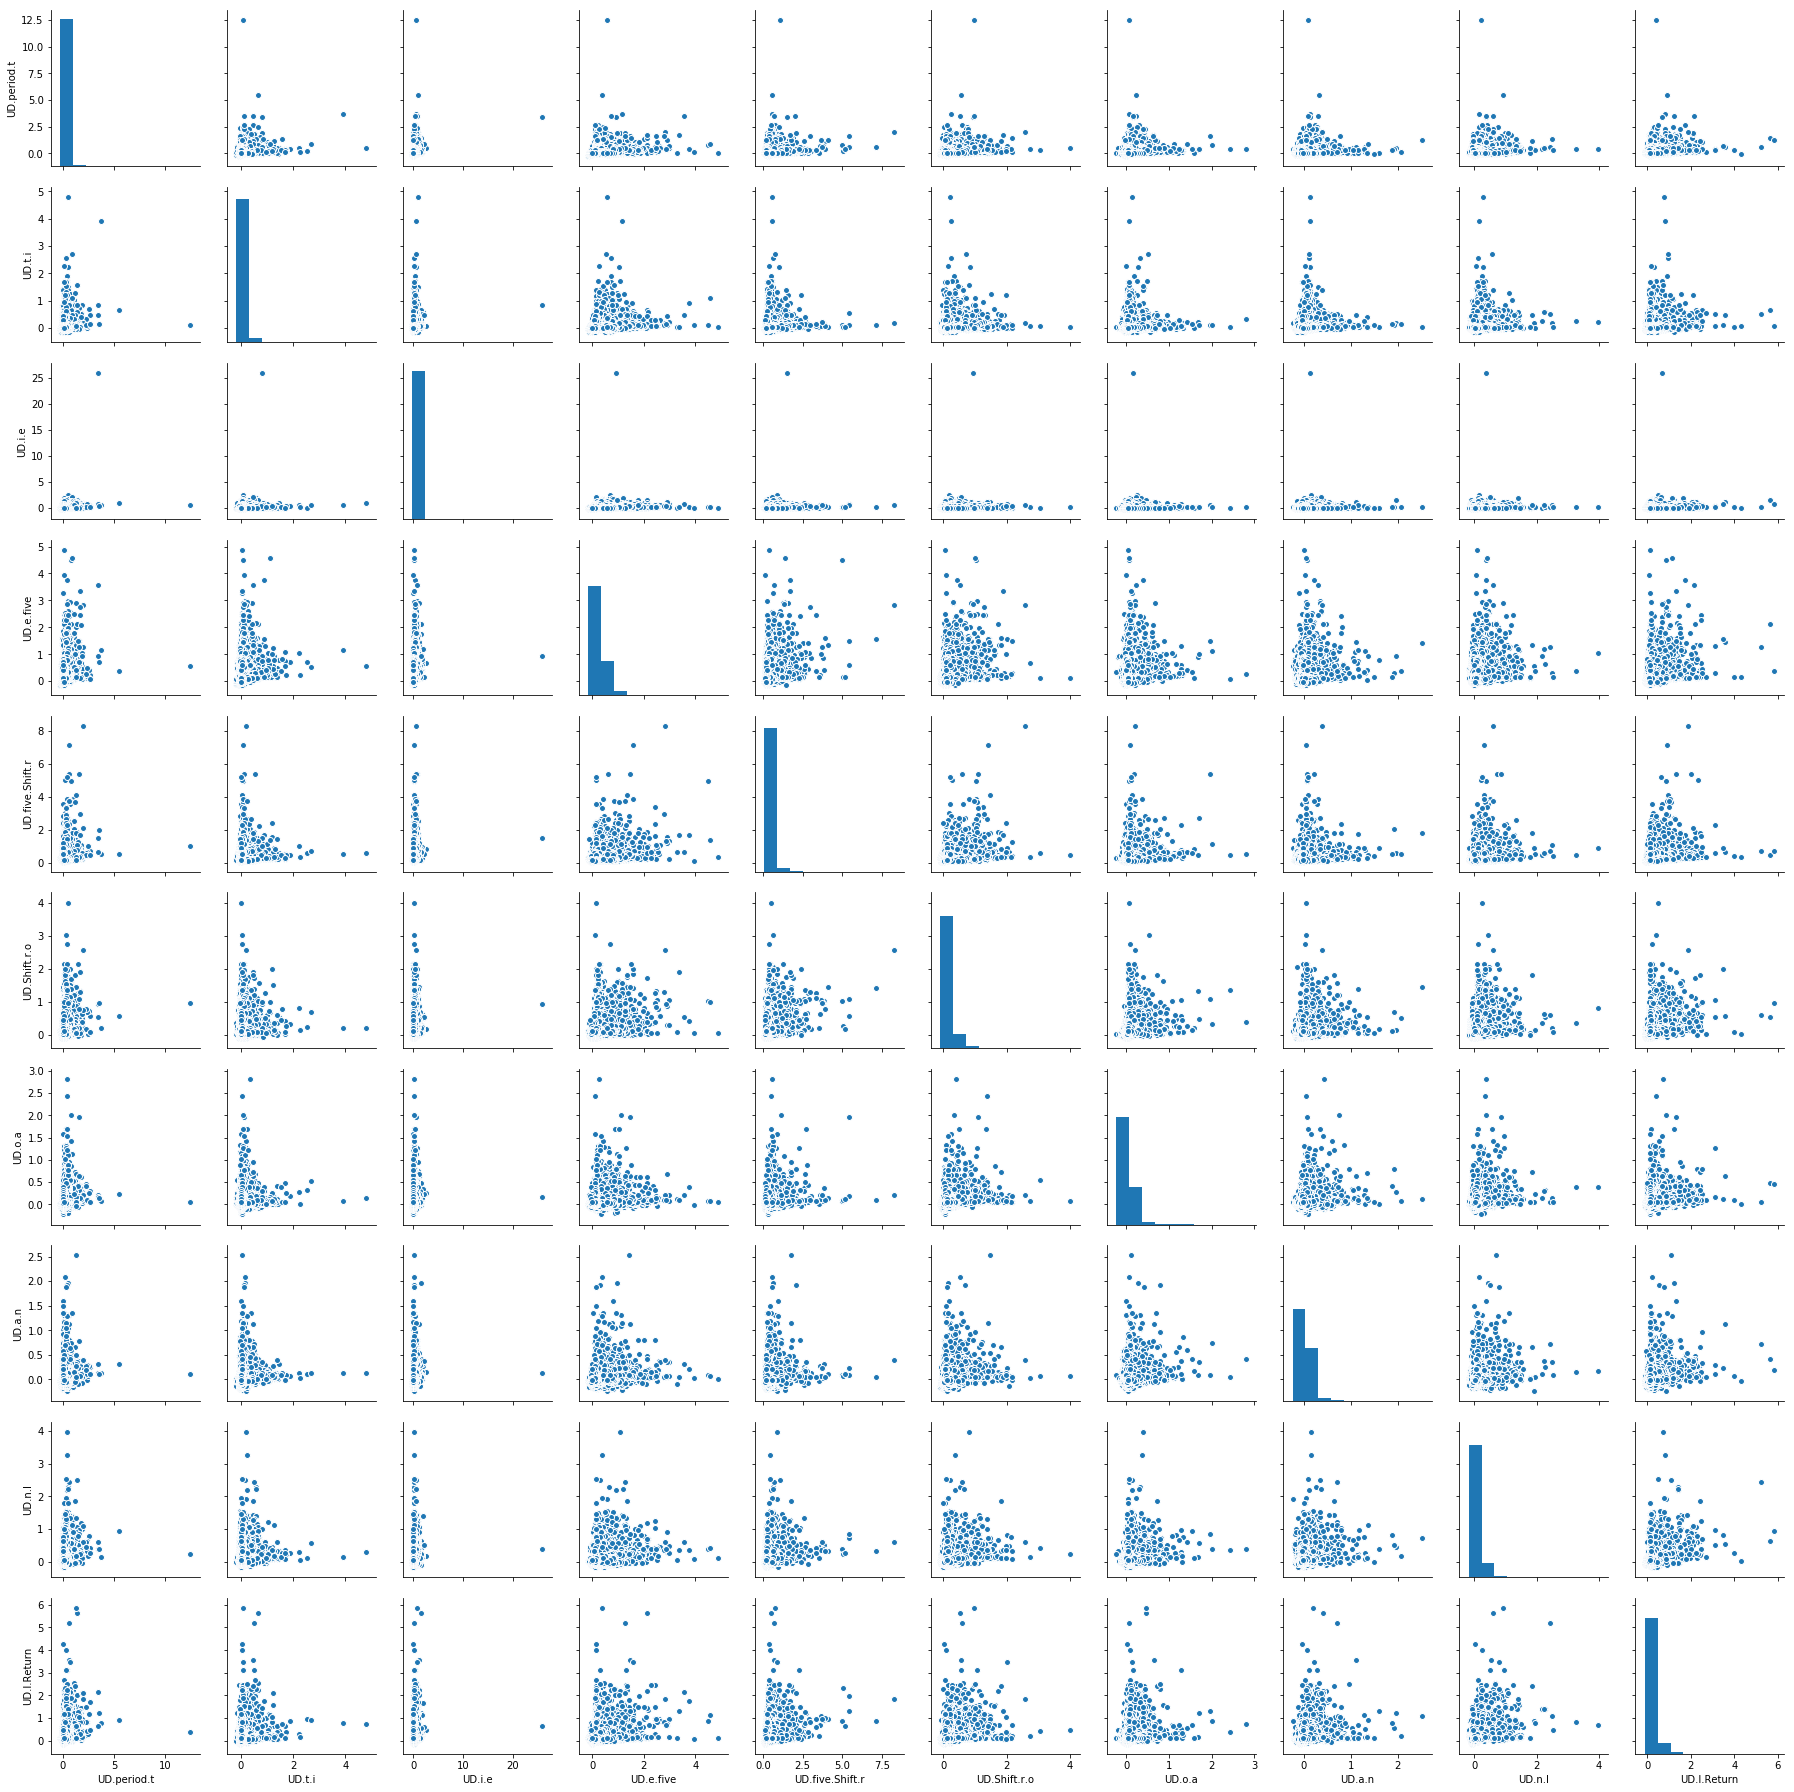

In [9]:
sns.pairplot(df.filter(['UD.period.t','UD.t.i','UD.i.e','UD.e.five','UD.five.Shift.r','UD.Shift.r.o','UD.o.a','UD.a.n','UD.n.l','UD.l.Return'],axis=1))

In [10]:
# Check for duplicate rows - there aren't any, this is good
df[df.duplicated()]

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return


In [11]:
# check for null values
print(df.isnull().sum())

subject            0
sessionIndex       0
rep                0
H.period           0
DD.period.t        0
UD.period.t        0
H.t                0
DD.t.i             0
UD.t.i             0
H.i                0
DD.i.e             0
UD.i.e             0
H.e                0
DD.e.five          0
UD.e.five          0
H.five             0
DD.five.Shift.r    0
UD.five.Shift.r    0
H.Shift.r          0
DD.Shift.r.o       0
UD.Shift.r.o       0
H.o                0
DD.o.a             0
UD.o.a             0
H.a                0
DD.a.n             0
UD.a.n             0
H.n                0
DD.n.l             0
UD.n.l             0
H.l                0
DD.l.Return        0
UD.l.Return        0
H.Return           0
dtype: int64


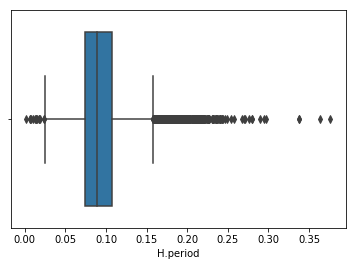

In [12]:
sns.boxplot(x=df["H.period"])

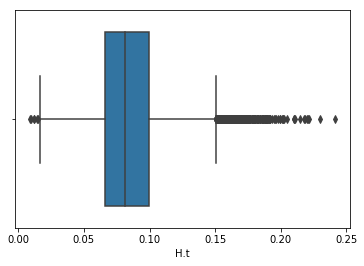

In [13]:
sns.boxplot(x=df["H.t"])

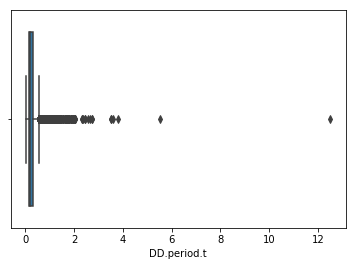

In [14]:
sns.boxplot(x=df["DD.period.t"])

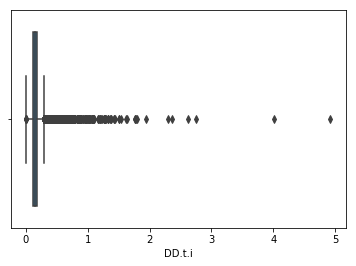

In [15]:
sns.boxplot(x=df["DD.t.i"])

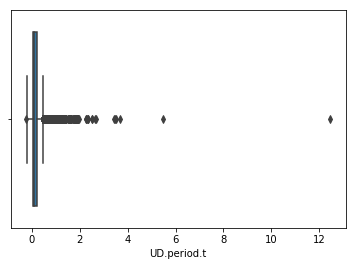

In [16]:
sns.boxplot(x=df["UD.period.t"])

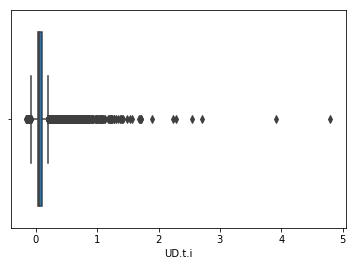

In [17]:
sns.boxplot(x=df["UD.t.i"])

So it looks like there are some serious outliers with UD and DD, but H has a more even spread.

# Model development

It is evident this is a classification problem, rather than a regression problem. 

Firstly, let's approach this using standard anomaly detection practices - we will train a model to recognise a certain user's typing pattern, and then test it against the remaining user's samples, from which we can obtain an anomaly score.

# Conclusion and Future Improvements
Things that could be looked at in future:
- Try multi-class classification vs anomaly detection.
    - Rather than training with respect to one user's data, then testing against the rest, with MCC you could use multiple user's samples to form decision boundaries wherein users could be distinguished.
- We have not accounted for correlations between dataset features (whereas in reality, DD values will be comprised of both H and UD components, implying correlation). We could retrain having normalised out these effects.
- There appear to be a lot of outliers present in the UD and DD data (considering the box plots). We could use some sort of filter (see Manhattan filter detector) to remove these components, and see if performance improves.
- Could implement hypothesis testing to verify our model is better than the others presented (rather than due to just random chance).
- Could look at other keystroke data available online (as mentioned in the paper) - although if we were to integrate it, we'd have to ensure it was recorded under similar conditions.